In [1]:
from foundry.util.runtime import setup
setup()

import foundry.numpy as npx
import foundry.train.console
import foundry.train
import foundry.models
import foundry.diffusion.nonparametric as nonparametric

import matplotlib.pyplot as plt
import matplotlib as mpl
import optax
import jax
import flax.linen as nn

from collections.abc import Sequence
from functools import partial

from foundry.models.embed import SinusoidalPosEmbed
from foundry.models import activation

from foundry.random import PRNGSequence
from foundry.data import PyTreeData
from foundry.train import LossOutput
from foundry.diffusion.ddpm import DDPMSchedule
from foundry.core import tree

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

import seaborn as sns
sns.set_theme()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})

In [2]:
schedule = DDPMSchedule.make_squaredcos_cap_v2(
    32, 
    prediction_type="epsilon",
    clip_sample_range=2.
)

class DiffusionMLP(nn.Module):
    features: Sequence[int] = (128, 128, 128, 128, 128)
    activation: str = "gelu"
    time_embed_dim: int = 64
    num_classes: int | None = None
    out_channels: int | None = None

    @nn.compact
    def __call__(self, x, t, cond=None, train=False):
        h = getattr(activation, self.activation)
        # works even if we have multiple timesteps
        embed = SinusoidalPosEmbed(self.time_embed_dim)(t)
        embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            h,
            nn.Dense(self.time_embed_dim),
        ])(embed)

        x, x_uf = tree.ravel_pytree(x)
        out_features = x.shape[-1]
        if cond is not None:
            cond, _ = tree.ravel_pytree(cond)
            x = npx.concatenate([x, cond], axis=-1)
        for feat in self.features:
            shift, scale = npx.split(nn.Dense(2*feat)(embed), 2, -1)
            x = h(nn.Dense(feat)(x))
            x = x * (1 + scale) + shift
        x = nn.Dense(out_features)(x)
        x = x_uf(x)
        return x

In [3]:
def normal_denoiser(mu, sigma, x, t):
    # x_t = sqrt(alpha_t) x_0 + sqrt(1 - alpha_t) * N(0, 1)
    # E[x_0 | x_t] = integral x_0 p(x_0 | x_t) dx_0
    # = integral x_0 p(x_t | x_0) p(x_0) / p(x_t) dx_0
    # p(x_t) is a normalization constant
    # p(x_t | x_0) = N(x_t; sqrt(alpha_t) * x_0, 1 - alpha_t)
    # p(x_t | x_0) prop N(x_0; x_t/sqrt(alpha_t), (1 - alpha_t)/alpha_t)

    # E[x_0 | x_t] = (x_t/sqrt(alpha_t) * sigma^2 + mu * (1 - alpha_t) / alpha_t) / (sigma^2 + (1 - alpha_t) / alpha_t)
    # = (x_t * sqrt(alpha_t) * sigma^2 + mu * (1 - alpha_t)) / (sigma^2 * alpha_t + (1 - alpha_t))
    alpha_t = schedule.alphas_cumprod[t]
    sqrt_alpha_t = npx.sqrt(alpha_t)
    sigma_sqr = sigma**2
    denoised = (x*sqrt_alpha_t*sigma_sqr + mu*(1 - alpha_t)) / (sigma_sqr*alpha_t + (1 - alpha_t))

    # p(x_t) = N(x_t; sqrt(alpha_t) mu, alpha_t sigma^2) + N(x_t; 0, 1 - alpha_t)
    #  = N(x_t; sqrt(alpha_t) mu, alpha_t sigma^2 + 1 - alpha_t)
    log_pdf = -(x - sqrt_alpha_t*mu)**2 / (2*(alpha_t*sigma_sqr + 1 - alpha_t))
    return denoised, log_pdf

def combine_denoisers(denoisers, x, t):
    xs =[]
    log_pfs = []
    for denoiser in denoisers:
        xi, log_pdf = denoiser(x, t)
        xs.append(xi)
        log_pfs.append(log_pdf)
    xs = npx.stack(xs)
    log_pdfs = npx.stack(log_pfs)
    norm = jax.scipy.special.logsumexp(log_pdfs)
    log_pdfs = log_pdfs - norm
    flow = npx.dot(npx.exp(log_pdfs), xs)
    return flow

In [4]:
def sample(rng_key):
    m_rng, n_rng = foundry.random.split(rng_key, 2)
    z, x = foundry.random.choice(m_rng, npx.array([[-1., -1.],
                                                [1., 0.],
                                                [1., 1.]]))
    n_a, n_b = 0.1*foundry.random.normal(n_rng, (2,))
    z = z
    x = x + n_b
    return (z, x)


def run_analysis(sampling_fn, interp_points, gt_flows, interp_fn):
    interp_points = npx.array(interp_points)
    raw_data = jax.vmap(sampling_fn)(foundry.random.split(foundry.random.key(42), 10*1024))
    data = PyTreeData(raw_data)

    model = DiffusionMLP()

    rng = PRNGSequence(42)

    vars = model.init(next(rng), npx.zeros(()), 
        npx.zeros((), dtype=npx.uint32), cond=npx.zeros(()))

    iterations = 30_000

    optimizer = optax.adamw(optax.cosine_decay_schedule(1e-4, iterations), weight_decay=5e-4)
    opt_state = optimizer.init(vars["params"])

    @foundry.train.batch_loss
    def loss(vars, rng_key, sample):
        z, x = sample
        loss = schedule.loss(rng_key, 
            lambda rng_key, x, t: model.apply(vars, x, t, cond=z),
            x
        )
        return LossOutput(
            loss=loss,
            metrics={"loss": loss}
        )

    data_stream = data.stream().shuffle(next(rng)).batch(512)

    with foundry.train.loop(data_stream,
        rng_key=next(rng), iterations=iterations
    ) as loop:
        for epoch in loop.epochs():
            for step in epoch.steps():
                opt_state, vars, metrics = foundry.train.step(
                    loss, optimizer, opt_state, vars, 
                    step.rng_key, step.batch
                )
                if step.iteration % 1000 == 0:
                    foundry.train.console.log(
                        step.iteration, metrics
                    )
        foundry.train.console.log(
            step.iteration, metrics
        )

    def nn_diffuser(z, rng_key, x, t):
        return model.apply(vars, x, t, cond=z)

    def lin_diffuser(z, rng_key, x, t):
        flows = npx.array(gt_flows(x, t))
        # flows = jax.vmap(nn_diffuser, in_axes=(0, None, None, None))(interp_points, rng_key, x, t)
        s = npx.array(interp_fn(z))
        flow = npx.sum(s * flows)
        return flow

    def nw_diffuser(z, rng_key, x, t):
        return nonparametric.nw_cond_diffuser(z, raw_data, schedule, 
                nonparametric.log_gaussian_kernel, 0.2)(x, t)

    @partial(jax.jit, static_argnums=(0,))
    def sample(diffuser, z, rng_key):
        sampler = lambda rng_key: (z, schedule.sample(rng_key, partial(diffuser, z), npx.zeros(()), eta=1.))
        zs, vs = jax.vmap(sampler)(foundry.random.split(rng_key, 2*1024))
        return zs, vs

    def batch_sample(diffuser, rng_key):
        zs = npx.linspace(-1, 1, 128)
        rngs = foundry.random.split(rng_key, zs.shape[0])
        zs, vs = jax.vmap(sample, in_axes=(None, 0, 0))(diffuser, zs, rngs)
        zs, vs = npx.stack((zs, vs), -1).reshape(-1, 2).T
        return (zs, vs)
    
    nn_samples = batch_sample(nn_diffuser, next(rng))
    nw_samples = batch_sample(nw_diffuser, next(rng))
    lin_samples = batch_sample(lin_diffuser, next(rng))

    return raw_data, nn_samples, lin_samples, nw_samples

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30000/30000 100% 0:00:00 0:01:29
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1500/1500   100% 0:00:00 0:01:29
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20/20       100% 0:00:00 0:00:00


[16:41:01] INFO     foundry.train -      0 | loss: 1.7262709140777588
[16:41:04] INFO     foundry.train -   1000 | loss: 0.20618797838687897
[16:41:07] INFO     foundry.train -   2000 | loss: 0.19221660494804382
[16:41:10] INFO     foundry.train -   3000 | loss: 0.2449299842119217
[16:41:13] INFO     foundry.train -   4000 | loss: 0.20224829018115997
[16:41:16] INFO     foundry.train -   5000 | loss: 0.22856539487838745
[16:41:18] INFO     foundry.train -   6000 | loss: 0.25014495849609375
[16:41:21] INFO     foundry.train -   7000 | loss: 0.19806741178035736
[16:41:24] INFO     foundry.train -   8000 | loss: 0.1952921748161316
[16:41:27] INFO     foundry.train -   9000 | loss: 0.20869134366512299
[16:41:30] INFO     foundry.train -  10000 | loss: 0.2284548133611679
[16:41:33] INFO     foundry.train -  11000 | loss: 0.19712206721305847
[16:41:36] INFO     foundry.train -  12000 | loss: 0.2161063551902771
[16:41:39] INFO     foundry.train -  13000 | loss: 0.18779787421226501
[16:41:41] 

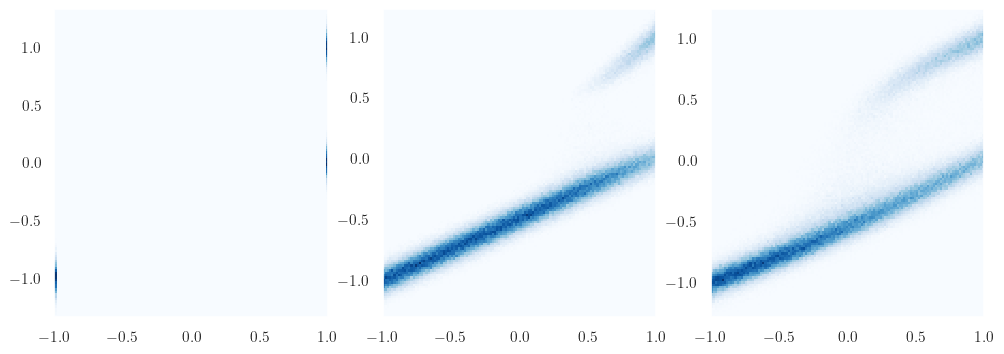

In [ ]:
def singular_sample(rng_key):
    m_rng, n_rng = foundry.random.split(rng_key, 2)
    z, x, s = foundry.random.choice(m_rng, npx.array([[-1., -1., 0.05],
                                                [1., 0., 0.1],
                                                [1., 1., 0.1]]))
    n_x = s*foundry.random.normal(n_rng, ())
    z = z
    x = x + n_x
    return (z, x)

def gt_flows(x, t):
    left_flow, _ = normal_denoiser(-1., 0.1, x, t)
    right_flow = combine_denoisers([
            partial(normal_denoiser, 0., 0.1),
            partial(normal_denoiser, 1., 0.1)
        ],
        x, t
    )
    left_flow = schedule.output_from_denoised(x, t, left_flow)
    right_flow = schedule.output_from_denoised(x, t, right_flow)
    return left_flow, right_flow

# def gt_flows(x, t):
#     left_flow, _ = normal_denoiser(-1., 0.05, x, t)

#     right_a, a_log_pdf = normal_denoiser(1., 0.1, x, t)
#     right_b, b_log_pdf = normal_denoiser(0., 0.1, x, t)

#     right_norm = npx.logaddexp(a_log_pdf, b_log_pdf)
#     a_log_pdf = a_log_pdf - right_norm
#     b_log_pdf = b_log_pdf - right_norm
#     right_flow = npx.exp(a_log_pdf) * right_a + npx.exp(b_log_pdf) * right_b

#     left_flow = schedule.output_from_denoised(x, t, left_flow)
#     right_flow = schedule.output_from_denoised(x, t, right_flow)
#     return left_flow, right_flow

def interp_fn(z):
    s = 0.5 * (1 + z)
    return 1 - s, s

s_raw_data, s_nn_samples, s_lin_samples, s_nw_samples = run_analysis(singular_sample, npx.array([-1., 1.]), gt_flows, interp_fn)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.hist2d(s_raw_data[0], s_raw_data[1], bins=[128, 128], cmap="Blues")
ax2.hist2d(s_lin_samples[0], s_lin_samples[1], bins=[128, 128], cmap="Blues")
ax3.hist2d(s_nn_samples[0], s_nn_samples[1], bins=[128, 128], cmap="Blues")
fig.show()


Iteration       ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 17020/30000  57% 0:00:37 0:00:48
Epoch           ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━  851/1500    57% 0:00:37 0:00:48
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/20         0% -:--:-- 0:00:00


[16:42:31] INFO     foundry.train -      0 | loss: 1.8108325004577637
[16:42:34] INFO     foundry.train -   1000 | loss: 0.2870022654533386
[16:42:37] INFO     foundry.train -   2000 | loss: 0.26204967498779297
[16:42:40] INFO     foundry.train -   3000 | loss: 0.3231164813041687
[16:42:42] INFO     foundry.train -   4000 | loss: 0.29714447259902954
[16:42:45] INFO     foundry.train -   5000 | loss: 0.28009575605392456
[16:42:48] INFO     foundry.train -   6000 | loss: 0.28131380677223206
[16:42:51] INFO     foundry.train -   7000 | loss: 0.27157914638519287
[16:42:54] INFO     foundry.train -   8000 | loss: 0.28748685121536255
[16:42:56] INFO     foundry.train -   9000 | loss: 0.29521000385284424
[16:42:59] INFO     foundry.train -  10000 | loss: 0.2613776922225952
[16:43:02] INFO     foundry.train -  11000 | loss: 0.2695770859718323
[16:43:05] INFO     foundry.train -  12000 | loss: 0.2665060758590698
[16:43:07] INFO     foundry.train -  13000 | loss: 0.286125510931015
[16:43:10] INF

[16:43:22] INFO     foundry.train -  18000 | loss: 0.3035283088684082
[16:43:25] INFO     foundry.train -  19000 | loss: 0.3020275831222534
[16:43:27] INFO     foundry.train -  20000 | loss: 0.2572595477104187
[16:43:30] INFO     foundry.train -  21000 | loss: 0.24426424503326416
[16:43:33] INFO     foundry.train -  22000 | loss: 0.28516092896461487
[16:43:36] INFO     foundry.train -  23000 | loss: 0.2532369792461395
[16:43:39] INFO     foundry.train -  24000 | loss: 0.260601669549942
[16:43:41] INFO     foundry.train -  25000 | loss: 0.26560017466545105
[16:43:44] INFO     foundry.train -  26000 | loss: 0.3362325131893158
[16:43:47] INFO     foundry.train -  27000 | loss: 0.23173320293426514
[16:43:50] INFO     foundry.train -  28000 | loss: 0.32152682542800903
[16:43:53] INFO     foundry.train -  29000 | loss: 0.25344735383987427
[16:43:55] INFO     foundry.train -  29999 | loss: 0.2402782291173935


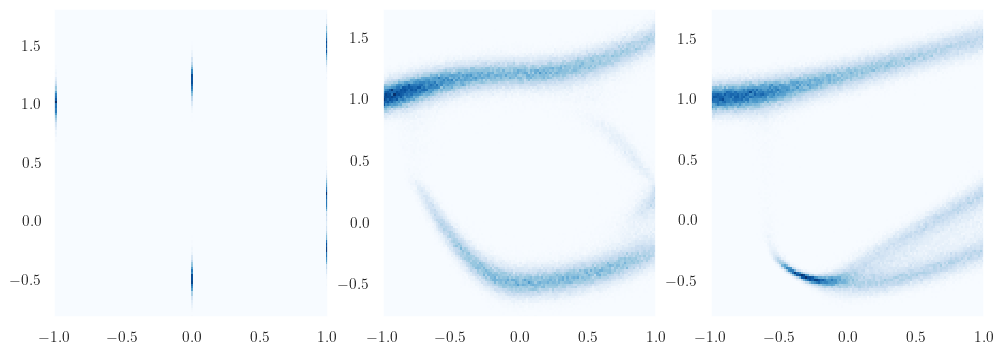

In [6]:
deltas = npx.array([
    [-1., 1.],
    [0., -0.5], [0., 1.2],
    [1., -0.25], [1., 0.2], [1., 1.5]
])

def singular_sample(rng_key):
    m_rng, n_rng = foundry.random.split(rng_key, 2)
    z, x = foundry.random.choice(m_rng, deltas)
    n_x = 0.1*foundry.random.normal(n_rng, ())
    z = z
    x = x + n_x
    return (z, x)

def gt_flows(x, t):
    left_flow, _ = normal_denoiser(1., 0.1, x, t)
    middle_flow = combine_denoisers([
            partial(normal_denoiser, -0.5, 0.1),
            partial(normal_denoiser, 1.2, 0.1)
        ],
        x, t
    )
    right_flow = combine_denoisers([
            partial(normal_denoiser, -0.25, 0.1),
            partial(normal_denoiser, 0.2, 0.1),
            partial(normal_denoiser, 1.5, 0.1)
        ],
        x, t
    )
    left_flow = schedule.output_from_denoised(x, t, left_flow)
    middle_flow = schedule.output_from_denoised(x, t, middle_flow)
    right_flow = schedule.output_from_denoised(x, t, right_flow)
    return left_flow, middle_flow, right_flow

def interp_fn(z):
    middle = (1 + z)*(1 - z)
    left = jax.lax.cond(z > 0., 
        lambda: 0.,
        lambda: 1 - middle
    )
    right = jax.lax.cond(z < 0., 
        lambda: 0.,
        lambda: 1 - middle
    )
    return left, middle, right

c_raw_data, c_nn_samples, c_lin_samples = run_analysis(singular_sample, npx.array([-1., 0., 1.]), gt_flows, interp_fn)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.hist2d(c_raw_data[0], c_raw_data[1], bins=[128, 128], cmap="Blues")
ax2.hist2d(c_lin_samples[0], c_lin_samples[1], bins=[128, 128], cmap="Blues")
ax3.hist2d(c_nn_samples[0], c_nn_samples[1], bins=[128, 128], cmap="Blues")
fig.show()

Iteration       ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━  7400/30000  25% 0:01:05 0:00:21
Epoch           ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━  370/1500    25% 0:01:05 0:00:21
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/20         0% -:--:-- 0:00:00


[16:43:58] INFO     foundry.train -      0 | loss: 1.7965238094329834
[16:44:01] INFO     foundry.train -   1000 | loss: 0.31120505928993225
[16:44:04] INFO     foundry.train -   2000 | loss: 0.2505221962928772
[16:44:07] INFO     foundry.train -   3000 | loss: 0.2715044915676117
[16:44:09] INFO     foundry.train -   4000 | loss: 0.2884860038757324
[16:44:12] INFO     foundry.train -   5000 | loss: 0.3030312657356262
[16:44:15] INFO     foundry.train -   6000 | loss: 0.262673944234848
[16:44:18] INFO     foundry.train -   7000 | loss: 0.2875211536884308


[16:44:21] INFO     foundry.train -   8000 | loss: 0.29363197088241577
[16:44:23] INFO     foundry.train -   9000 | loss: 0.3405199646949768
[16:44:26] INFO     foundry.train -  10000 | loss: 0.25502997636795044
[16:44:29] INFO     foundry.train -  11000 | loss: 0.25997495651245117
[16:44:32] INFO     foundry.train -  12000 | loss: 0.26563817262649536
[16:44:35] INFO     foundry.train -  13000 | loss: 0.26066848635673523
[16:44:37] INFO     foundry.train -  14000 | loss: 0.3203774392604828
[16:44:40] INFO     foundry.train -  15000 | loss: 0.308713436126709
[16:44:43] INFO     foundry.train -  16000 | loss: 0.24674281477928162
[16:44:46] INFO     foundry.train -  17000 | loss: 0.2404768466949463
[16:44:49] INFO     foundry.train -  18000 | loss: 0.30356544256210327
[16:44:52] INFO     foundry.train -  19000 | loss: 0.27010250091552734
[16:44:54] INFO     foundry.train -  20000 | loss: 0.24705173075199127
[16:44:57] INFO     foundry.train -  21000 | loss: 0.24863585829734802
[16:45:00] 

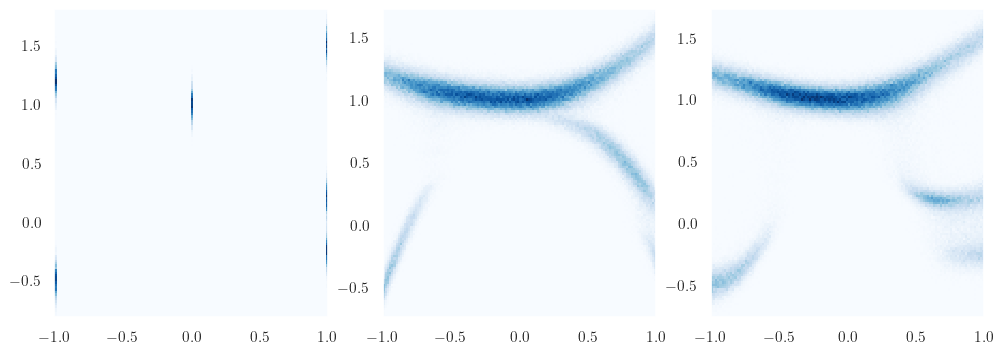

In [7]:
deltas = npx.array([
    [-1., -0.5], [-1., 1.2],
    [0., 1.],
    [1., -0.25], [1., 0.2], [1., 1.5]
])
def singular_sample(rng_key):
    m_rng, n_rng = foundry.random.split(rng_key, 2)
    z, x = foundry.random.choice(m_rng, deltas)
    n_x = 0.1*foundry.random.normal(n_rng, ())
    z = z
    x = x + n_x
    return (z, x)

def gt_flows(x, t):
    middle_flow, _ = normal_denoiser(1., 0.1, x, t)
    left_flow = combine_denoisers([
            partial(normal_denoiser, -0.5, 0.1),
            partial(normal_denoiser, 1.2, 0.1)
        ],
        x, t
    )
    right_flow = combine_denoisers([
            partial(normal_denoiser, -0.25, 0.1),
            partial(normal_denoiser, 0.2, 0.1),
            partial(normal_denoiser, 1.5, 0.1)
        ],
        x, t
    )
    left_flow = schedule.output_from_denoised(x, t, left_flow)
    middle_flow = schedule.output_from_denoised(x, t, middle_flow)
    right_flow = schedule.output_from_denoised(x, t, right_flow)
    return left_flow, middle_flow, right_flow

def interp_fn(z):
    middle = (1 + z)*(1 - z)
    left = jax.lax.cond(z > 0., 
        lambda: 0.,
        lambda: 1 - middle
    )
    right = jax.lax.cond(z < 0., 
        lambda: 0.,
        lambda: 1 - middle
    )
    return left, middle, right

cc_raw_data, cc_nn_samples, cc_lin_samples = run_analysis(singular_sample, npx.array([-1., 0., 1.]), gt_flows, interp_fn)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.hist2d(cc_raw_data[0], cc_raw_data[1], bins=[128, 128], cmap="Blues")
ax2.hist2d(cc_lin_samples[0], cc_lin_samples[1], bins=[128, 128], cmap="Blues")
ax3.hist2d(cc_nn_samples[0], cc_nn_samples[1], bins=[128, 128], cmap="Blues")
fig.show()

Iteration       ━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 19040/30000  63% 0:00:35 0:00:54
Epoch           ━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━  952/1500    63% 0:00:32 0:00:54
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/20         0% 0:00:01 0:00:00


[16:45:25] INFO     foundry.train -      0 | loss: 1.723388671875
[16:45:28] INFO     foundry.train -   1000 | loss: 0.21167060732841492
[16:45:31] INFO     foundry.train -   2000 | loss: 0.2021874189376831
[16:45:34] INFO     foundry.train -   3000 | loss: 0.26122838258743286
[16:45:36] INFO     foundry.train -   4000 | loss: 0.1989770233631134
[16:45:39] INFO     foundry.train -   5000 | loss: 0.24284552037715912
[16:45:42] INFO     foundry.train -   6000 | loss: 0.2351144403219223
[16:45:45] INFO     foundry.train -   7000 | loss: 0.1941053420305252
[16:45:47] INFO     foundry.train -   8000 | loss: 0.18936687707901
[16:45:50] INFO     foundry.train -   9000 | loss: 0.23740512132644653
[16:45:53] INFO     foundry.train -  10000 | loss: 0.22965151071548462
[16:45:56] INFO     foundry.train -  11000 | loss: 0.21499526500701904
[16:45:59] INFO     foundry.train -  12000 | loss: 0.22207263112068176
[16:46:02] INFO     foundry.train -  13000 | loss: 0.18149229884147644
[16:46:04] INFO   

[16:46:22] INFO     foundry.train -  20000 | loss: 0.19263941049575806
[16:46:24] INFO     foundry.train -  21000 | loss: 0.18735548853874207
[16:46:27] INFO     foundry.train -  22000 | loss: 0.18067380785942078
[16:46:30] INFO     foundry.train -  23000 | loss: 0.21849726140499115
[16:46:33] INFO     foundry.train -  24000 | loss: 0.1764807254076004
[16:46:35] INFO     foundry.train -  25000 | loss: 0.19276109337806702
[16:46:38] INFO     foundry.train -  26000 | loss: 0.21060246229171753
[16:46:41] INFO     foundry.train -  27000 | loss: 0.17626652121543884
[16:46:44] INFO     foundry.train -  28000 | loss: 0.23158562183380127
[16:46:47] INFO     foundry.train -  29000 | loss: 0.2005440592765808
[16:46:49] INFO     foundry.train -  29999 | loss: 0.1445309817790985


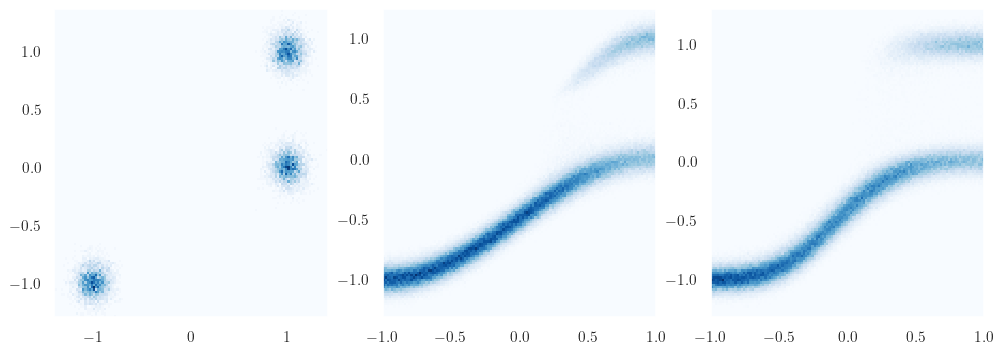

In [8]:
def singular_sample(rng_key):
    m_rng, n_rng = foundry.random.split(rng_key, 2)
    z, x = foundry.random.choice(m_rng, npx.array([[-1., -1.],
                                                [1., 0.],
                                                [1., 1.]]))
    n_x, n_y = 0.1*foundry.random.normal(n_rng, (2,))
    z = z + n_y
    x = x + n_x
    return (z, x)

def gt_flows(x, t):
    left_flow, _ = normal_denoiser(-1., 0.1, x, t)
    right_flow = combine_denoisers([
            partial(normal_denoiser, 0., 0.1),
            partial(normal_denoiser, 1., 0.1)
        ],
        x, t
    )
    left_flow = schedule.output_from_denoised(x, t, left_flow)
    right_flow = schedule.output_from_denoised(x, t, right_flow)
    return left_flow, right_flow

def interp_fn(z):
    s = 0.5 * (1 + z)
    s = (npx.sin((2*s - 1)*npx.pi/2) + 1)/2
    return 1 - s, s

ss_raw_data, ss_nn_samples, ss_lin_samples = run_analysis(singular_sample, npx.array([-1., 1.]), gt_flows, interp_fn)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.hist2d(ss_raw_data[0], ss_raw_data[1], bins=[128, 128], cmap="Blues")
ax2.hist2d(ss_lin_samples[0], ss_lin_samples[1], bins=[128, 128], cmap="Blues")
ax3.hist2d(ss_nn_samples[0], ss_nn_samples[1], bins=[128, 128], cmap="Blues")
fig.show()

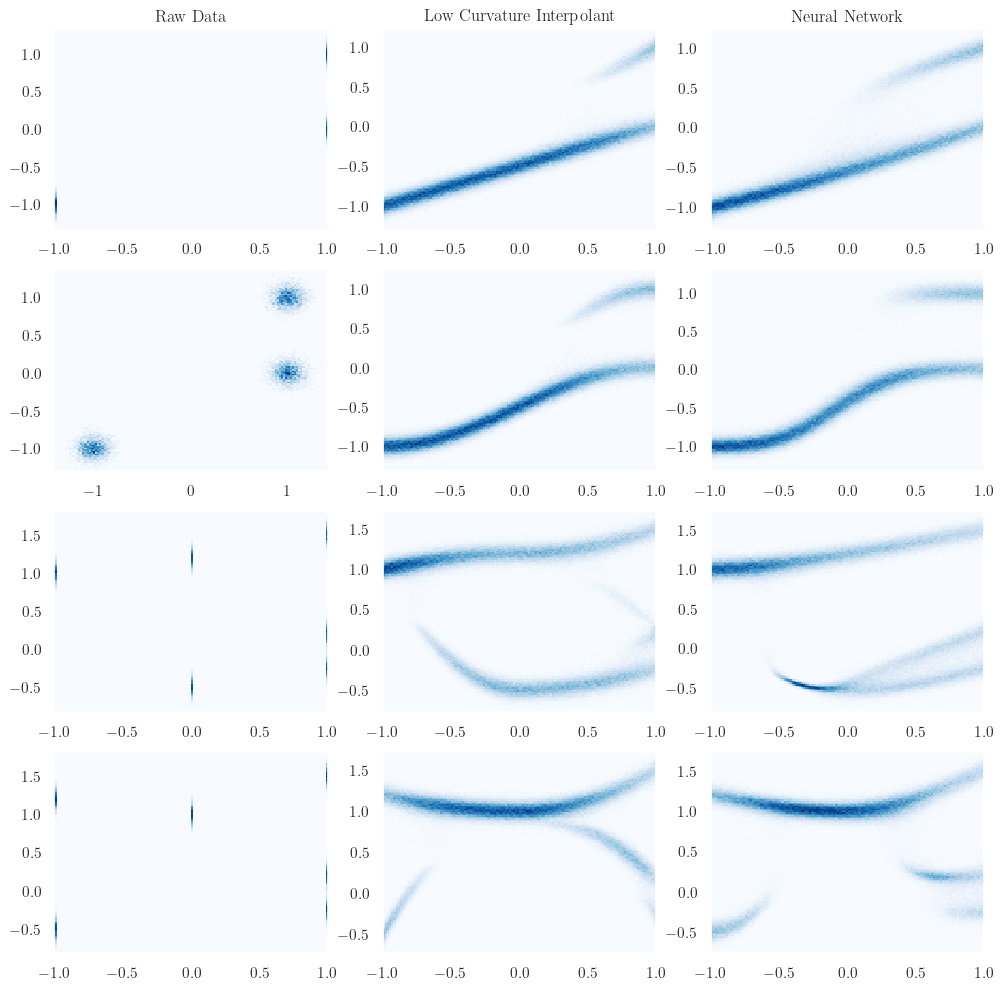

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(12, 12))


ax1.set_title("Raw Data")
ax2.set_title("Low Curvature Interpolant")
ax3.set_title("Neural Network")

ax1.hist2d(s_raw_data[0], s_raw_data[1], bins=[128, 128], cmap="Blues")
ax2.hist2d(s_lin_samples[0], s_lin_samples[1], bins=[128, 128], cmap="Blues")
ax3.hist2d(s_nn_samples[0], s_nn_samples[1], bins=[128, 128], cmap="Blues")

ax4.hist2d(ss_raw_data[0], ss_raw_data[1], bins=[128, 128], cmap="Blues")
ax5.hist2d(ss_lin_samples[0], ss_lin_samples[1], bins=[128, 128], cmap="Blues")
ax6.hist2d(ss_nn_samples[0], ss_nn_samples[1], bins=[128, 128], cmap="Blues")

ax7.hist2d(c_raw_data[0], c_raw_data[1], bins=[128, 128], cmap="Blues")
ax8.hist2d(c_lin_samples[0], c_lin_samples[1], bins=[128, 128], cmap="Blues")
ax9.hist2d(c_nn_samples[0], c_nn_samples[1], bins=[128, 128], cmap="Blues")

ax10.hist2d(cc_raw_data[0], cc_raw_data[1], bins=[128, 128], cmap="Blues")
ax11.hist2d(cc_lin_samples[0], cc_lin_samples[1], bins=[128, 128], cmap="Blues")
ax12.hist2d(cc_nn_samples[0], cc_nn_samples[1], bins=[128, 128], cmap="Blues")

fig.savefig("different_interpolants_deeper.pdf", bbox_inches="tight")
fig.show()